El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

from src.datasets import daocensus, to_microsoft
from src.model_selection import timeIntervalSplit

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


In [2]:
# Dataset splits config
N_SPLITS: int = 100
SKIP_SPLIT: int = 1

K_RECOMMENDATIONS: List[int] = [5, 10]

ORG_NAME: str = 'Decentraland'

## Load data

In [3]:
dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
print(dfv.info())
print(dfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 7.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942 entries, 0 to 1941
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------ 

In [4]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0xe7af1c70f8f089c4c3bd71999692c6c5a15d9e2a,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 12:28:01,1
1,0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 02:16:23,1
2,0xd82d005e8f8d5385db40ba23884a5c967bb1e8af,b86aa059-3d31-5d41-a472-70962816f779,2021-12-17 00:38:22,1
3,0xf4c64db66ffb301985f5ecd85c8f3f9c02f2659d,b86aa059-3d31-5d41-a472-70962816f779,2021-12-16 18:47:08,1
4,0xd5e9ef1cedad0d135d543d286a2c190b16cbb89e,b86aa059-3d31-5d41-a472-70962816f779,2021-12-16 18:32:15,1


## Exploring data

### How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                         1942
mean     8 days 02:39:25.396498455
std      3 days 01:18:26.795947483
min                5 days 00:00:00
25%                7 days 00:00:00
50%                7 days 00:00:00
75%                7 days 00:00:00
max               14 days 00:00:00
dtype: object

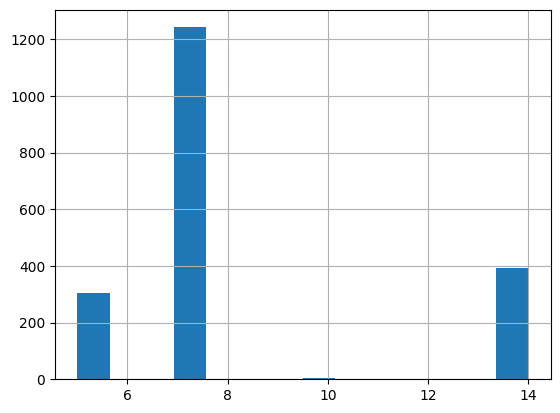

In [5]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### What day or the week are proposals created

0    346
1    326
2    324
3    305
4    257
5    199
6    185
Name: start, dtype: int64

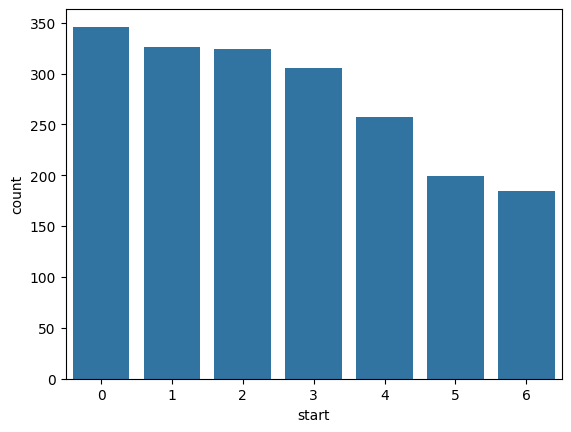

In [6]:
import seaborn as sns

sns.countplot(x=dfp['start'].dt.dayofweek)
dfp['start'].dt.dayofweek.value_counts()

### How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

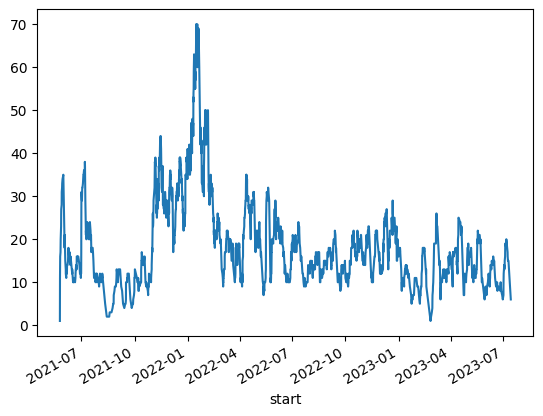

In [7]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [8]:
from recommenders.datasets.pandas_df_utils import filter_by

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""
def getBaselineRecommendations(train: pd.DataFrame, users, proposals, k: int = 5, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    # bestVotes = bestVotes[bestVotes.index.isin(proposals)]

    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    # Avoid recommending already voted proposals (they wont be in the test set)
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

## Evaluating the baseline recommendator

In [9]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [10]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [11]:
from functools import partial

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 
metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    current_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]
    print(f"Currently open proposals: {len(current_proposals)}")

    train_filtered = train[train['itemID'].isin(current_proposals['id']) ]
    test_filtered = test[test['itemID'].isin(current_proposals['id']) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), test_filtered['itemID'].unique(), k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-06-09 04:21:07)  =====
Currently open proposals: 14
Train votes in open proposals: 228
Test votes in open proposals:  105

===== Training on fold 1 (t: 2021-06-16 22:05:04)  =====
Currently open proposals: 11
Train votes in open proposals: 108
Test votes in open proposals:   45

===== Training on fold 2 (t: 2021-06-24 19:22:47)  =====
Currently open proposals: 15
Train votes in open proposals: 267
Test votes in open proposals:   94

===== Training on fold 3 (t: 2021-07-02 14:13:49)  =====
Currently open proposals: 31
Train votes in open proposals: 235
Test votes in open proposals:   64

===== Training on fold 4 (t: 2021-07-10 07:22:00)  =====
Currently open proposals: 21
Train votes in open proposals: 309
Test votes in open proposals:   47

===== Training on fold 5 (t: 2021-07-17 22:22:00)  =====
Currently open proposals: 17
Train votes in open proposals: 173
Test votes in open proposals:   32

===== Training on fold 6 (t: 2021-07-25 23:05:36)  =====
C

In [12]:
# Save the data
pd.DataFrame(metrics).to_csv(f'./data/baseline-mp-{ORG_NAME}.csv', index=False)

,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10,perfect precision@5,perfect precision@10
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.189607,0.361967,0.279850,0.157922,0.449464,0.337838,0.398567,0.229273
std,0.069249,0.172187,0.164083,0.048111,0.156085,0.155833,0.091822,0.073841
min,0.036364,0.048883,0.022039,0.056667,0.114106,0.061356,0.217778,0.108889
25%,0.141697,0.247895,0.171045,0.126384,0.349915,0.242204,0.327636,0.178046
50%,0.187755,0.337601,0.258754,0.148649,0.449374,0.313677,0.391304,0.212245
75%,0.241156,0.435252,0.367181,0.185263,0.536281,0.431646,0.459736,0.269537
max,0.352423,0.953866,0.937500,0.313656,0.953866,0.937500,0.608850,0.500885


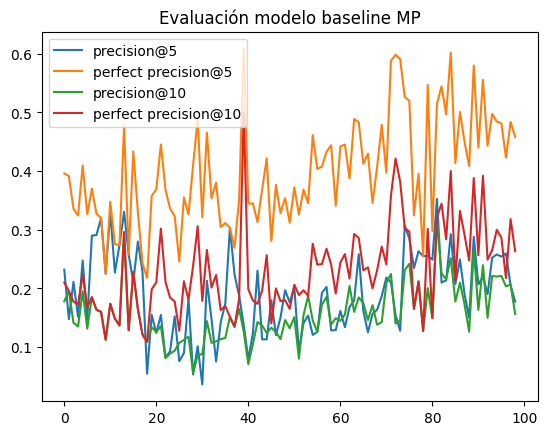

In [13]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10
count,99.000000,99.0,99.000000,99.000000,99.0,99.000000
mean,0.398567,1.0,0.961913,0.229273,1.0,0.991946
std,0.091822,0.0,0.038877,0.073841,0.0,0.012317
min,0.217778,1.0,0.781040,0.108889,1.0,0.943608
25%,0.327636,1.0,0.951244,0.178046,1.0,0.989106
50%,0.391304,1.0,0.971141,0.212245,1.0,0.998227
75%,0.459736,1.0,0.988538,0.269537,1.0,1.000000
max,0.608850,1.0,1.000000,0.500885,1.0,1.000000


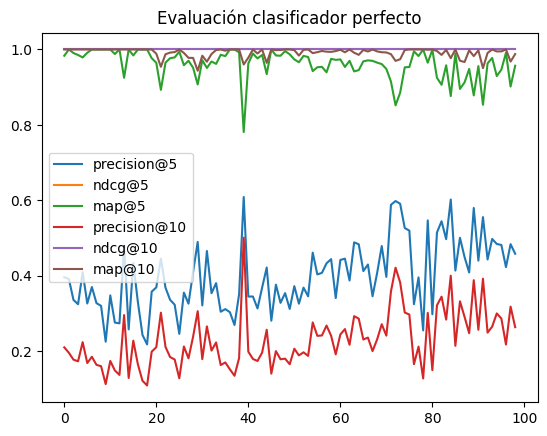

In [14]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()